<a href="https://colab.research.google.com/github/NREL/NREL-Beam-Characterization/blob/main/SimulatedNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cv2
from sklearn import mixture 
import scipy.stats as stats 
%matplotlib inline
import skimage 
from scipy.interpolate import griddata
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian2d, lorentzian
import skimage.draw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 6.6 MB/s eta 0:00:00


In [ ]:
def pl_ellipse(x0, y0, sx, sy, th):
    """Return points to plot an ellipse"""
    t = np.linspace(0,2*np.pi)
    x = sx * np.cos(t)
    y = sy * np.sin(t)
    xrot = x * np.cos(th) - y * np.sin(th) + x0
    yrot = x * np.sin(th) + y * np.cos(th) + y0
    return (xrot, yrot)

(x_ell, y_ell) = pl_ellipse(300, 200, 50, 25, np.deg2rad(30))
#plt.plot(x_ell, y_ell)
#plt.axis('equal')
#plt.grid()

pass

# Simulate a Gaussian Beam

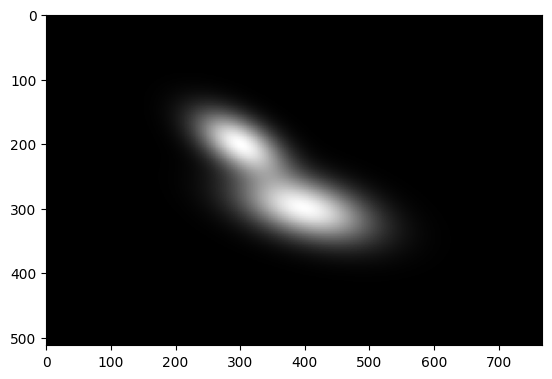

(512, 768)
(393216, 1)


In [ ]:
# Size of image
nx = 768
ny = 512

# Noise
noise = 0

# Positions of Gaussians
x0s = (300,400,)
y0s = (200,300,)
I0s = (1000,1000,) # Peak intensity
sxs = (50,70,)  # Standard deviations 
sys = (25,30,)
thetas = (30,15,) # In degrees

# Make axes
x = np.arange(nx)
y = np.arange(ny)

# Create image with uniform noise
image = noise * np.random.random((ny,nx))

# Add Gaussian peaks to image
for i in range(len(x0s)):
    x0 = x0s[i]
    y0 = y0s[i]
    I0 = I0s[i]
    sx = sxs[i]
    sy = sys[i]
    theta_deg = thetas[i]
    th = np.deg2rad(thetas[i])
    #print(x0,y0,I0, sx, sy, th)
    # Get ellipsoid parameters
    a = np.cos(th)**2 / (2 * sx**2) + np.sin(th)**2 / (2 * sy**2)
    b = -0.25 * np.sin(2 * th) * (-1 / sx**2 + 1 / sy**2)
    c = np.sin(th)**2 / (2 * sx**2) + np.cos(th)**2 / (2 * sy**2)
    # Add Gaussian to image
    image += I0 * np.exp(-( \
                           a * (x[None,:]-x0)**2 + \
                           2 * b * (x[None,:]-x0) * (y[:,None]-y0) + \
                           c * (y[:,None]-y0)**2 \
                          ))
    (x_ell, y_ell) = pl_ellipse(x0, y0, sx, sy, np.deg2rad(theta_deg))
    #plt.plot(x0, y0, '.', c='red')
    #plt.plot(x_ell, y_ell, '-r')


image = np.array(255 * image / np.max(image), dtype=np.uint8)
    
int_image = np.array(image, dtype=np.uint8)
plt.imshow(int_image, interpolation='nearest', cmap='gray')
plt.show()

print(image.shape)
img2 = image.reshape((-1,1))
print(img2.shape)
#X = image[:, ::-1] # flip axes for better plotting

# Apply Gaussian Mixture Model


In [ ]:
from sklearn.mixture import GaussianMixture as GMM

In [ ]:
gmm_model = GMM(n_components=4, covariance_type = 'tied').fit(img2)
gmm_labels = gmm_model.predict(img2)

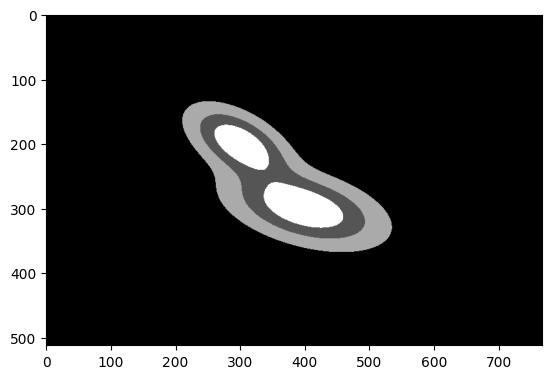

In [ ]:
original_shape = image.shape
segmented = gmm_labels.reshape(original_shape[0], original_shape[1])
plt.imshow(segmented, cmap='gray')

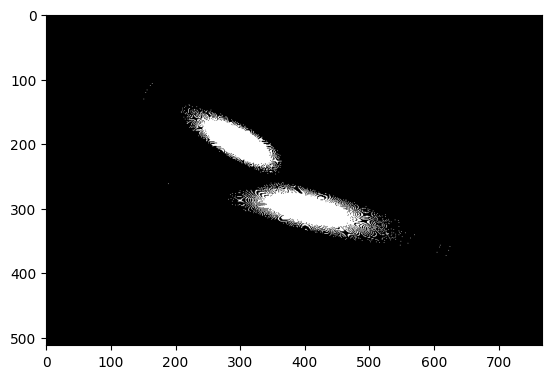

In [ ]:
Im_th = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 0)
#Im_th = Im_th[:, ::-1] # flip axes for better plotting
plt.imshow(Im_th, cmap='gray')

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
g = mixture.GaussianMixture(n_components=2, covariance_type= 'tied').fit(Im_th)

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
  
        
def plot_gmm(gmm, Im_th, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(Im_th).predict(Im_th)
    if label:
        ax.scatter(Im_th[:, 0], Im_th[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(Im_th[:, 0], Im_th[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    #w_factor = 0.2 / gmm.weights_.max()
    #for pos, covar, w in zip(gmm.means_, gmm.covariance_, gmm.weights_):
     #   draw_ellipse(pos, covar, alpha=w * w_factor)
        

In [ ]:
#There is some issue with the plotting. I realized that GMM is good for image segmentation, but not for fitting functions

#plot_gmm(g, Im_th)

# Simulate a two-dimensional off-axis Lorentzian

In [ ]:
def lorentzian2d(x, y, amplitude=1., centerx=0., centery=0., sigmax=1., sigmay=1.,
                 rotation=0):
    """Return a two dimensional lorentzian.

    The maximum of the peak occurs at ``centerx`` and ``centery``
    with widths ``sigmax`` and ``sigmay`` in the x and y directions
    respectively. The peak can be rotated by choosing the value of ``rotation``
    in radians.
    """
    xp = (x - centerx)*np.cos(rotation) - (y - centery)*np.sin(rotation)
    yp = (x - centerx)*np.sin(rotation) + (y - centery)*np.cos(rotation)
    R = (xp/sigmax)**2 + (yp/sigmay)**2

    return 2*amplitude*lorentzian(R)/(np.pi*sigmax*sigmay)

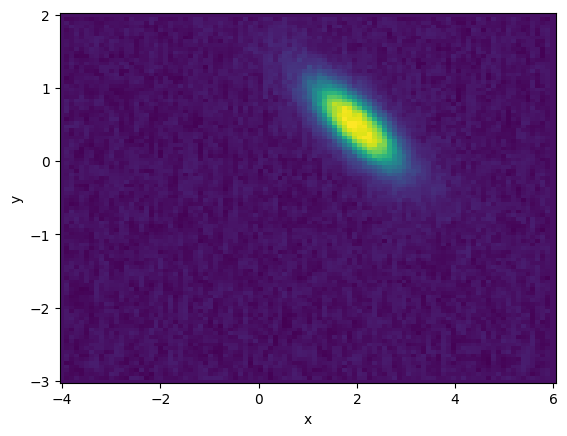

In [ ]:
# Size of image
nx = 768
ny = 512

# Noise
noise = 0


# Make axes
x = np.arange(nx)
y = np.arange(ny)

# Create image with uniform noise
image = noise * np.random.random((ny,nx))



npoints = 10000
x = np.random.rand(npoints)*10 - 4
y = np.random.rand(npoints)*5 - 3

z = lorentzian2d(x, y, amplitude=30, centerx=2, centery=.5, sigmax=0.9,
                 sigmay=.3, rotation=30*np.pi/180)
z += 2*(np.random.rand(*z.shape)-.5)
error = np.sqrt(z+1)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                   np.linspace(y.min(), y.max(), 100))
#X, Y = np.meshgrid(np.linspace(0, 512, 100),
                   #np.linspace(0, 768, 100))

Z = griddata((x, y), z, (X, Y), method='linear', fill_value=0)


fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
art = ax.pcolor(X, Y, Z, shading='auto')
#plt.colorbar(art, ax=ax, label='z')
plt.show()

#Using Lmfit to find best fit function

In [ ]:
model = lmfit.Model(lorentzian2d, independent_vars=['x', 'y'])
params = model.make_params(amplitude=10, centerx=x[np.argmax(z)],
                           centery=y[np.argmax(z)])
params['rotation'].set(value=.1, min=0, max=np.pi/2)
params['sigmax'].set(value=1, min=0)
params['sigmay'].set(value=2, min=0)

result = model.fit(z, x=x, y=y, params=params, weights=1/error)
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 10000
    # variables        = 6
    chi-square         = 16159.9950
    reduced chi-square = 1.61696968
    Akaike info crit   = 4811.53652
    Bayesian info crit = 4854.79856
    R-squared          = 0.76103001
[[Variables]]
    amplitude:  27.3715680 +/- 0.55855911 (2.04%) (init = 10)
    centerx:    1.99885800 +/- 0.01283277 (0.64%) (init = 2.172383)
    centery:    0.50220866 +/- 0.00854411 (1.70%) (init = 0.3636294)
    sigmax:     0.84685935 +/- 0.01673344 (1.98%) (init = 1)
    sigmay:     0.27324087 +/- 0.00558932 (2.05%) (init = 2)
    rotation:   0.52986563 +/- 0.00948504 (1.79%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(centerx, centery)  = -0.7534
    C(amplitude, sigmay) = +0.2434
    C(amplitude, sigmax) = +0.1894


In [ ]:
Cx = result.best_values['centerx']
Cy = result.best_values['centery']
Center = (Cx,Cy)
print('Cx = %.3g ' %Cx)
print('Cy = %.3g ' %Cy)
print(Center)

Cx = 2 
Cy = 0.502 
(1.99885800431253, 0.5022086588250756)


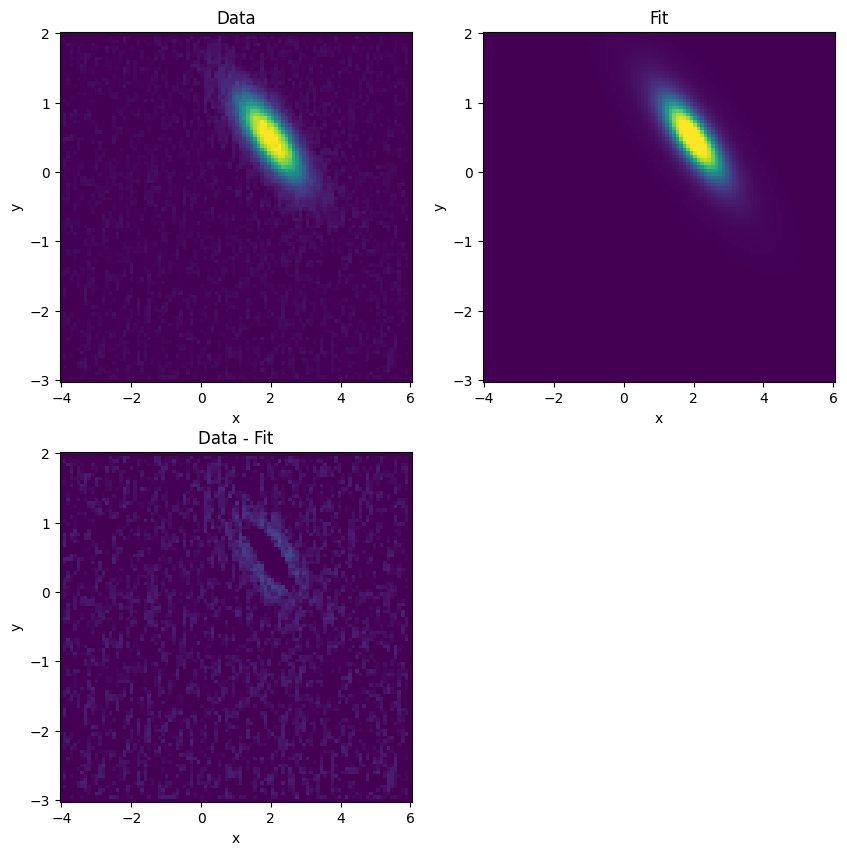

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

vmax = np.nanpercentile(Z, 99.9)

ax = axs[0, 0]
art = ax.pcolor(X, Y, Z, vmin=0, vmax=vmax, shading='auto')
#plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data')

ax = axs[0, 1]
fit = model.func(X, Y, **result.best_values)
art = ax.pcolor(X, Y, fit, vmin=0, vmax=vmax, shading='auto')
#plt.colorbar(art, ax=ax, label='z')
ax.set_title('Fit')

ax = axs[1, 0]
fit = model.func(X, Y, **result.best_values)
art = ax.pcolor(X, Y, Z-fit, vmin=0, vmax=10, shading='auto')
#plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data - Fit')

for ax in axs.ravel():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
axs[1, 1].remove()
plt.show()